# Sensitivity analysis for synaptic input parameters

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sim.nwbio as nwbio

import key_parser as ks
import preprocessing

In [115]:
# get the table
tab = ks.analyze_key([ nwbio.FileReader('baseline_firing_rate_0.nwb'),
                     nwbio.FileReader('baseline_firing_rate_bis_0.nwb')] )

In [116]:
tab.head()

,state,cellid,seed,g_mod,section_name,section_index,section_arc,var_type,file_object,key
0,normal,1.0,0.0,0.00050,somatic,0,0.5,v,<sim.nwbio.FileReader object at 0x7fc88fea8a00>,output-cellid=1-seed=0-tstop=15s-g_mod=0.0005....
1,normal,1.0,0.0,0.00075,somatic,0,0.5,v,<sim.nwbio.FileReader object at 0x7fc88fea8a00>,output-cellid=1-seed=0-tstop=15s-g_mod=0.00075...
2,normal,1.0,0.0,0.00100,somatic,0,0.5,v,<sim.nwbio.FileReader object at 0x7fc88fea8a00>,output-cellid=1-seed=0-tstop=15s-g_mod=0.001.s...
3,normal,1.0,0.0,0.00125,somatic,0,0.5,v,<sim.nwbio.FileReader object at 0x7fc88fea8a00>,output-cellid=1-seed=0-tstop=15s-g_mod=0.00125...
4,normal,10.0,0.0,0.00050,somatic,0,0.5,v,<sim.nwbio.FileReader object at 0x7fc88fea8a00>,output-cellid=10-seed=0-tstop=15s-g_mod=0.0005...


In [117]:
# these columns do not matter for our analysis
tab.drop(['cellid', 'seed', 'section_name', 'section_index', 'section_arc', 'var_type'], axis=1, inplace=True)

In [118]:
tab.columns

Index(['state', 'g_mod', 'file_object', 'key'], dtype='object')

In [119]:
# let's add the action potential count and baseline membrane voltage
for idx, row in tab.iterrows():
    trace = row['file_object'].read(row['key'])
    tab.loc[idx, 'firing rate'] = preprocessing.get_spike_count(*trace, tinit=5000.0, threshold=-30) / 10.0
    tab.loc[idx, 'baseline v'] = preprocessing.get_baseline_voltage(*trace)
    
del idx, row, trace # clean

/home/francesco/MeMo/preprocessing.py:69: ComplexWarning: Casting complex values to real discards the imaginary part
  v = np.fft.ifft(sig_fft).astype(float)
/home/francesco/MeMo/preprocessing.py:69: ComplexWarning: Casting complex values to real discards the imaginary part
  v = np.fft.ifft(sig_fft).astype(float)


In [120]:
# check data types
tab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   state        108 non-null    object 
 1   g_mod        108 non-null    float64
 2   file_object  108 non-null    object 
 3   key          108 non-null    object 
 4   firing rate  108 non-null    float64
 5   baseline v   108 non-null    float64
dtypes: float64(3), object(3)
memory usage: 5.2+ KB


In [121]:
# set the data types
for col in tab.columns:
    # eliminate excess of decimal digits
    if col.startswith('g_') or col.startswith('NmdaAmpaRatio'):
        tab[col] = tab[col].apply(lambda x: round(x, 5) if not np.isnan(x) else np.nan)

In [122]:
# let's sort the columns
tab = tab[['state', 'file_object', 'key', 'firing rate', 'baseline v', 'g_mod']]

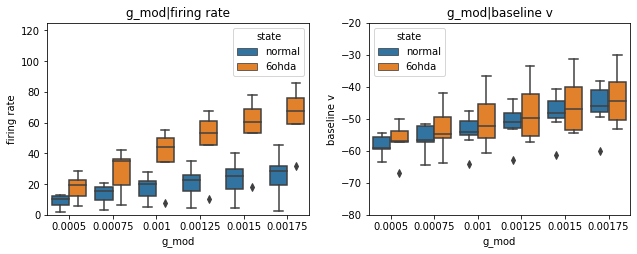

In [125]:
# rows 
nrow = tab.shape[1] - 5

# figure size
fig = plt.figure(figsize=(18, 15 / 4.0 * nrow))

for i, colx in enumerate(tab.drop(['file_object', 'key', 'state', 'firing rate', 'baseline v'], axis=1).columns):
    
    # select the parameter column and drop the rows with NaNs
    tmp = tab[[colx, 'firing rate', 'baseline v', 'state']].dropna()
    
    # plot ap count and baseline
    for j, coly in enumerate(['firing rate', 'baseline v']):
        plt.subplot(nrow, 4, i * 2 + j + 1)
        plt.title('%s|%s' % (colx, coly))
        sns.boxplot(data=tmp, x=colx, y=coly, hue='state')
        plt.ylim([0, 125] if j == 0 else [ -80, -20])

# spacing
plt.tight_layout(pad=1.5)
plt.show()

In [126]:
tab.groupby(['g_mod', 'state'])[['firing rate']].mean()

firing rate
g_mod   state              
0.00050 6ohda     17.860000
        normal     9.038462
0.00075 6ohda     27.880000
        normal    13.915385
0.00100 6ohda     38.460000
        normal    17.738462
0.00125 6ohda     47.480000
        normal    20.892308
0.00150 6ohda     55.720000
        normal    23.607692
0.00175 6ohda     63.960000
        normal    25.900000